# Rt for India 

In [3]:
import pandas as pd
import numpy as np
import requests
import json

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = ['Andaman and Nicobar Islands',
 'Puducherry',
 'Goa',
 'Manipur',
 'Tripura',
 'Mizoram',
 'Meghalaya',
 'Arunachal Pradesh',
 'Nagaland']


%config InlineBackend.figure_format = 'retina'

In [5]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


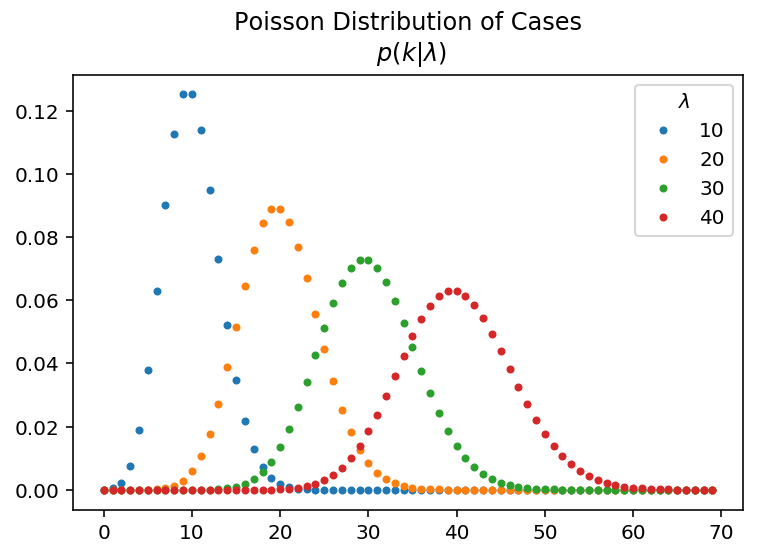

In [6]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

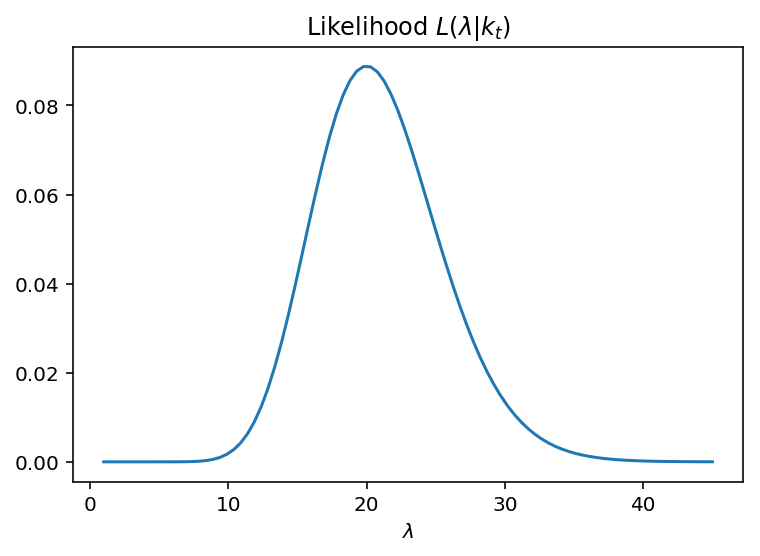

In [7]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $L\left(\lambda|k_t\right)$');


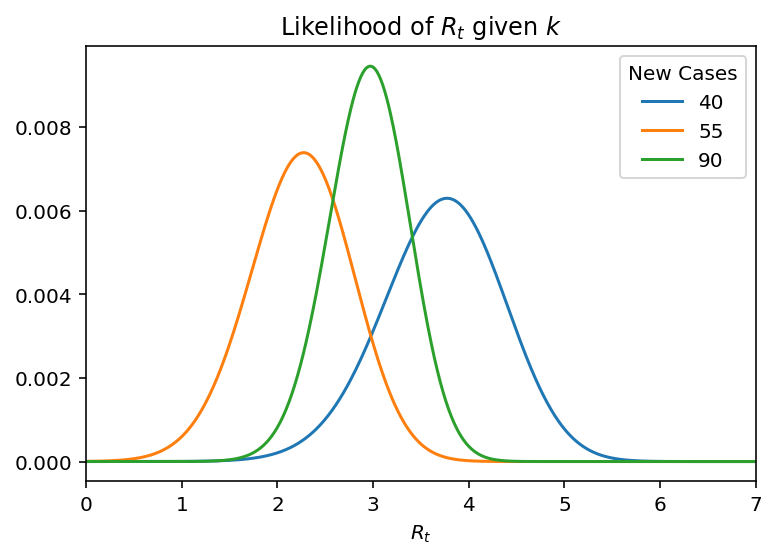

In [8]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,7)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

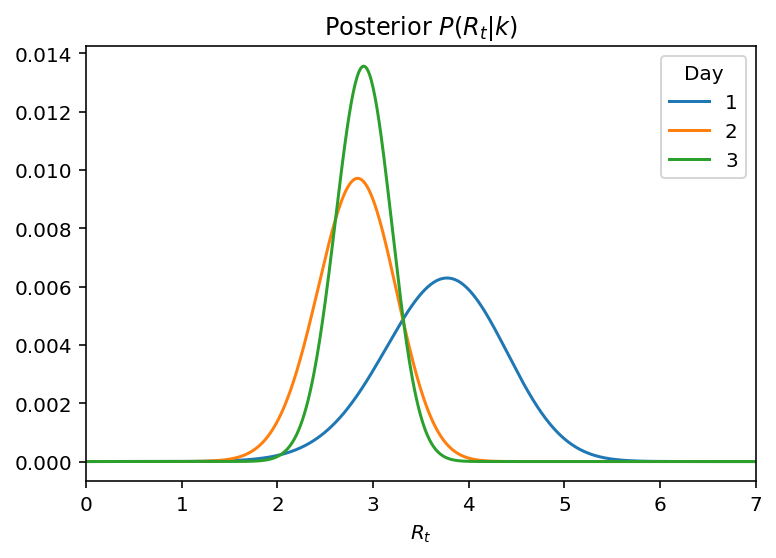

In [9]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,7)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [10]:
most_likely_values = posteriors.idxmax(axis=0)


In [11]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)

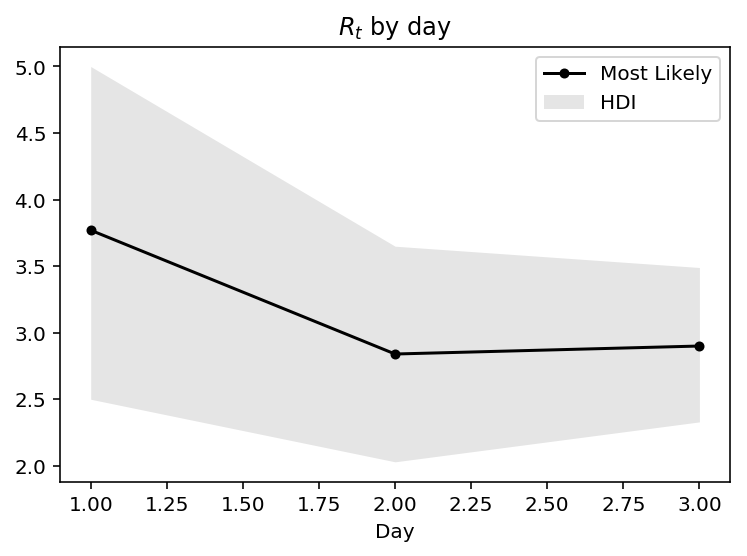

In [12]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low'],
                hdi['High'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();


In [13]:
def get_covid_india_data_api(url):
    response = requests.request("GET", url)
    return response.text.encode('utf8')

def flatten_and_parse_states_data(covid_data):
    flattened_data = []
    for day_data in covid_data:
        for region in day_data['regional']:
            flattened_data.append({
                'date' : day_data['day'],
                'state' : region['loc'],
                'case' : region['totalConfirmed']
            })
    
    states=pd.DataFrame(flattened_data)
    states.date = pd.to_datetime(states.date)
    return states

def fetch_covid_india_data(url):
    try:
        covid_data_json = get_covid_india_data_api(url)
        covid_data = json.loads(covid_data_json)['data']
        return flatten_and_parse_states_data(covid_data)
    except:
        print("API call failed")

In [14]:
url = "https://api.rootnet.in/covid19-in/stats/history"

states_df = fetch_covid_india_data(url)

In [15]:
states_df = states_df[states_df.state.str.contains('#')== False]

In [16]:
states_df[states_df.state !='Jharkhand#']
states = states_df.set_index(['state','date']).squeeze()

In [21]:
!pip install --upgrade scipy

     |████████████████████████████████| 28.8 MB 109 kB/s eta 0:00:01     |███████████████████▉            | 17.9 MB 39 kB/s eta 0:04:40     |████████████████████            | 18.1 MB 48 kB/s eta 0:03:43     |███████████████████████▊        | 21.4 MB 218 kB/s eta 0:00:34
  Attempting uninstall: scipy
    Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


In [27]:
!pip install 'scipy == 1.2.0'

     |████████████████████████████████| 28.8 MB 91 kB/s eta 0:00:011     |████████████████████████▍       | 22.0 MB 91 kB/s eta 0:01:15
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4
